In [2]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
  Using cached transformers-4.53.1-py3-none-any.whl.metadata (40 kB)
Using cached transformers-4.53.1-py3-none-any.whl (10.8 MB)
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
# ✅ 1. Import library
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [4]:
# ✅ 2. Clean text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\b(?:com|www|http|https|twitter|facebook|tiktok|instagram|youtube)\b", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"\([^)]*\)", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [5]:
# ✅ 3. Load and preprocess test dataset
df = pd.read_csv("../cleandata/test_hoax_dataset_2025.csv")
df["cleaned"] = df["cleaned"].astype(str).apply(clean_text)
df["label"] = df["label"].astype(int)

# ✅ 4. Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df[["cleaned", "label"]])

In [14]:
# ✅ 5. Tokenization
model_path = "../trained_model/checkpoint-600"
tokenizer = AutoTokenizer.from_pretrained(model_path)

def tokenize(batch):
    return tokenizer(batch["cleaned"], truncation=True, padding="max_length", max_length=256)

tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.rename_column("label", "labels")
tokenized = tokenized.remove_columns(["cleaned"]).with_format("torch")

TypeError: _path_isfile: path should be string, bytes, os.PathLike or integer, not NoneType

In [7]:
# ✅ 6. Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

# ✅ 7. Prediction
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in torch.utils.data.DataLoader(tokenized, batch_size=16):
        inputs = {k: v for k, v in batch.items() if k != "labels"}
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, axis=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

In [8]:
# ✅ 8. Evaluation Metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
accuracy = accuracy_score(all_labels, all_preds)

print("📊 Evaluation on Test Dataset 2025:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

📊 Evaluation on Test Dataset 2025:
Accuracy : 0.7608
Precision: 0.9573
Recall   : 0.6015
F1-Score : 0.7388


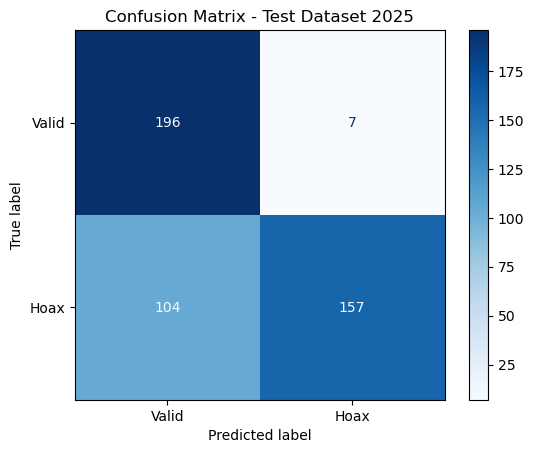

In [9]:

# ✅ 9. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Valid", "Hoax"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Dataset 2025")
plt.show()


In [10]:
from sklearn.metrics import roc_auc_score

# Hitung probabilitas (bukan prediksi kelas)
probs = []

with torch.no_grad():
    for batch in torch.utils.data.DataLoader(tokenized, batch_size=16):
        inputs = {k: v for k, v in batch.items() if k != "labels"}
        outputs = model(**inputs)
        prob = torch.softmax(outputs.logits, dim=1)[:, 1]  # probabilitas kelas 1 (hoax)
        probs.extend(prob.cpu().numpy())

roc_auc = roc_auc_score(all_labels, probs)
print(f"ROC-AUC  : {roc_auc:.4f}")


ROC-AUC  : 0.9513


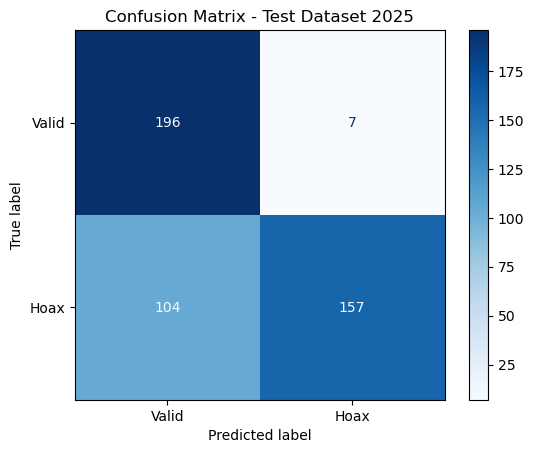


🔎 Classification Report:
              precision    recall  f1-score   support

       Valid       0.65      0.97      0.78       203
        Hoax       0.96      0.60      0.74       261

    accuracy                           0.76       464
   macro avg       0.81      0.78      0.76       464
weighted avg       0.82      0.76      0.76       464



In [11]:
from sklearn.metrics import classification_report

# Confusion Matrix & Report
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Valid", "Hoax"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Dataset 2025")
plt.show()

# Laporan Lengkap
print("\n🔎 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Valid", "Hoax"]))
